In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

from functools import reduce
from itertools import combinations

from scipy import stats

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# configure pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [3]:
home = 1

In [4]:
if home:
    dpath = '/Users/cglab/projects/abcd/data/abcd5.1-rser/'
else:
    dpath = '/home/cglab/projects/abcd/data/abcd5.1-rser/'

### Load ADI Deprivation indicators
* 3 that as used in grant

In [4]:
adi = pd.read_csv(dpath + 'abcd5.1_adi_dep_ind4-6.csv')
adi.rename(columns={'src_subject_id': 'subID'}, inplace=True)
adi.head()

,reshist_addr1_adi_edu_l,reshist_addr1_adi_sp,reshist_addr1_adi_unemp,subID,eventname
0,4.861931,29.079160,9.991899,NDAR_INV005V6D2C,baseline_year_1_arm_1
1,3.559711,0.000000,6.254295,NDAR_INV007W6H7B,baseline_year_1_arm_1
2,0.635838,5.863454,3.420132,NDAR_INV00BD7VDC,baseline_year_1_arm_1
3,2.196885,15.349195,7.476038,NDAR_INV00CY2MDM,baseline_year_1_arm_1
4,0.612392,13.073593,3.634927,NDAR_INV00NPMHND,baseline_year_1_arm_1


In [5]:
# drop eventname cause not needed since df is in wide form
adi.drop(columns=['eventname'], inplace=True)
adi.isnull().sum()

reshist_addr1_adi_edu_l    1
reshist_addr1_adi_sp       1
reshist_addr1_adi_unemp    1
subID                      0
dtype: int64

In [6]:
adi.shape

(11215, 4)

### Load Harsh SES/Deprivation Indicators
* for
* family deprivation index (computed already by Linhao)
* income poverty ratio

In [7]:
lf = pd.read_csv(dpath + "abcd5.1_grant_deprivation_indicators.csv")
lf.rename(columns={'subid': 'subID'}, inplace=True)
lf.head()

,subID,adi_perc_W1,Pedu_R_W1,fam_dep_W1,Pmeg_R_W1,empl_R_W1,IPR_W1
0,NDAR_INV003RTV85,,4,0,0,0,2.23248456396387
1,NDAR_INV005V6D2C,32,5,0,0,1,
2,NDAR_INV007W6H7B,2,1,0,0,0,9.96254084641747
3,NDAR_INV00BD7VDC,45,1,0,0,0,9.72724796700517
4,NDAR_INV00CY2MDM,66,3,.142857142857143,1,0,1.43030221444437


In [8]:
lf.shape

(11883, 7)

### check for duplicate subjects

In [9]:
duplicates = lf[lf.duplicated('subID', keep=False)]
print(duplicates)

                  subID adi_perc_W1 Pedu_R_W1 fam_dep_W1 Pmeg_R_W1 empl_R_W1            IPR_W1
1132   NDAR_INV2ZA2LC3N           1         1          0         0         0  9.96254084641747
1133   NDAR_INV2ZA2LC3N                                                                       
1311   NDAR_INV3E0WVH3G          51         3          0         1         1  1.88952572904201
1312   NDAR_INV3E0WVH3G                                                                       
6806   NDAR_INVJ9GNXGK5          15         2          0         0         0  12.8106584678452
6807   NDAR_INVJ9GNXGK5                                                                       
10589  NDAR_INVWE1DE80Z          53         1          0         0         0  3.48688929624611
10590  NDAR_INVWE1DE80Z                                                                       
11058  NDAR_INVXN6HMGK8          53         1          0         0         0  3.48688929624611
11059  NDAR_INVXN6HMGK8                           

In [10]:
# drop duplicate subs and keep first
lf = lf.drop_duplicates(subset='subID')
# ensure duplicates dropped
duplicates = lf[lf.duplicated('subID', keep=False)]
print(duplicates)

Empty DataFrame
Columns: [subID, adi_perc_W1, Pedu_R_W1, fam_dep_W1, Pmeg_R_W1, empl_R_W1, IPR_W1]
Index: []


In [11]:
lf.isnull().sum()

subID          0
adi_perc_W1    0
Pedu_R_W1      0
fam_dep_W1     0
Pmeg_R_W1      0
empl_R_W1      0
IPR_W1         0
dtype: int64

In [12]:
lf.dtypes

subID          object
adi_perc_W1    object
Pedu_R_W1      object
fam_dep_W1     object
Pmeg_R_W1      object
empl_R_W1      object
IPR_W1         object
dtype: object

In [13]:
# Replace empty strings with NaN
lf.replace(' ', np.nan, inplace=True)
indicators = ['adi_perc_W1', 'Pedu_R_W1', 'fam_dep_W1', 'Pmeg_R_W1', 'empl_R_W1', 'IPR_W1']
# convert to float
lf[indicators] = lf[indicators].astype(float)
lf.dtypes

subID           object
adi_perc_W1    float64
Pedu_R_W1      float64
fam_dep_W1     float64
Pmeg_R_W1      float64
empl_R_W1      float64
IPR_W1         float64
dtype: object

In [14]:
# check missing 
lf.isnull().sum()

subID             0
adi_perc_W1     697
Pedu_R_W1        16
fam_dep_W1       24
Pmeg_R_W1        98
empl_R_W1        58
IPR_W1         1213
dtype: int64

In [15]:
lf[indicators].describe()

,adi_perc_W1,Pedu_R_W1,fam_dep_W1,Pmeg_R_W1,empl_R_W1,IPR_W1
count,11181.000000,11862.000000,11854.000000,11780.000000,11820.000000,10665.000000
mean,39.248368,2.259568,0.068269,0.263328,0.304822,3.859395
std,27.312141,1.168243,0.159174,0.440457,0.460352,2.819187
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.048645
25%,18.000000,1.000000,0.000000,0.000000,0.000000,1.594632
50%,33.000000,2.000000,0.000000,0.000000,0.000000,3.271395
75%,57.000000,3.000000,0.000000,1.000000,1.000000,5.836349
max,100.000000,5.000000,1.000000,1.000000,1.000000,15.746048


### Impute Missing

In [16]:
dfi = lf[indicators]
# initiate imputer object
imp = IterativeImputer(random_state=0)
# impute and return transfromed array
dfi_imp = imp.fit_transform(dfi)
# # round to integer, to match response options
# dfi_imp = np.round(dfi_imp, 0)

# convert to dataframe for ease of processing
dfimp = pd.DataFrame(dfi_imp, columns=dfi.columns)
dfimp['subID'] = lf['subID'].tolist()
dfimp.head()

,adi_perc_W1,Pedu_R_W1,fam_dep_W1,Pmeg_R_W1,empl_R_W1,IPR_W1,subID
0,48.924301,4.0,0.000000,0.0,0.0,2.232485,NDAR_INV003RTV85
1,32.000000,5.0,0.000000,0.0,1.0,1.123686,NDAR_INV005V6D2C
2,2.000000,1.0,0.000000,0.0,0.0,9.962541,NDAR_INV007W6H7B
3,45.000000,1.0,0.000000,0.0,0.0,9.727248,NDAR_INV00BD7VDC
4,66.000000,3.0,0.142857,1.0,0.0,1.430302,NDAR_INV00CY2MDM


In [17]:
# check missing 
dfimp.isnull().sum()

adi_perc_W1    0
Pedu_R_W1      0
fam_dep_W1     0
Pmeg_R_W1      0
empl_R_W1      0
IPR_W1         0
subID          0
dtype: int64

In [18]:
dpath

'/home/cglab/projects/abcd/data/abcd5.1-rser/'

In [19]:
dfimp.to_csv(dpath + 'linhao_deprivation_indicators_cl.csv', index=False)

### Load HSES LF summary score 
* created in lavaan

In [20]:
lfs = pd.read_csv(dpath + 'lf_scores_hses1_grant.csv')
print(lfs.shape)
lfs.head()

(9881, 2)


,HSES1g,subID
0,0.422107,NDAR_INV003RTV85
1,-0.714240,NDAR_INV007W6H7B
2,-0.717965,NDAR_INV00BD7VDC
3,0.143257,NDAR_INV00CY2MDM
4,0.351656,NDAR_INV00HEV6HB


### Load full RSER dataframe

In [21]:
rser = pd.read_csv(dpath + 'abcd5.1_rtmri_2b_epn_cort_subc_net_ders_thrt_demo1_qcr_urg_dep_wide_lf.csv', low_memory=False)
rser.shape

(9933, 1383)

In [22]:
rser.dtypes

subID                    object
Aware                   float64
NoAcpt                  float64
Implse                  float64
Goals                   float64
                         ...   
erq_feelings_think_9    float64
erq_reapp_3_7           float64
erq_reapp_4_9           float64
erq_supp_3_7            float64
erq_supp_4_9            float64
Length: 1383, dtype: object

In [23]:
rser[['nAmygL1', 'nAmygR1']].isnull().sum()

nAmygL1    966
nAmygR1    966
dtype: int64

In [24]:
rser[['eAmygL1', 'eAmygR1']].isnull().sum()

eAmygL1    968
eAmygR1    968
dtype: int64

### Merge Imputed Indicator df with RSER df

In [25]:
rser = rser.merge(dfimp, how="left", on="subID")
rser.shape

(9933, 1389)

In [26]:
rser[indicators].isnull().sum()

adi_perc_W1    0
Pedu_R_W1      0
fam_dep_W1     0
Pmeg_R_W1      0
empl_R_W1      0
IPR_W1         0
dtype: int64

In [27]:
dfimp.describe()

,adi_perc_W1,Pedu_R_W1,fam_dep_W1,Pmeg_R_W1,empl_R_W1,IPR_W1
count,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000,11878.000000
mean,39.372205,2.259922,0.068398,0.264885,0.305209,3.717505
std,26.773595,1.167725,0.159056,0.439187,0.459343,2.787334
min,-3.713408,1.000000,0.000000,0.000000,-0.037512,-2.494797
25%,19.000000,1.000000,0.000000,0.000000,0.000000,1.481985
50%,34.000000,2.000000,0.000000,0.000000,0.000000,3.127346
75%,56.000000,3.000000,0.000000,1.000000,1.000000,5.836349
max,100.000000,5.000000,1.000000,1.000000,1.000000,15.746048


### Merge ADI df with RSER df

In [28]:
print(rser.shape)
rser = rser.merge(adi, how="left", on="subID")
rser.shape

(9933, 1389)


(9933, 1392)

### Merge LFS df with RSER df

In [29]:
print(rser.shape)
rser = rser.merge(lfs, how="left", on="subID")
rser.shape

(9933, 1392)


(9933, 1393)

#### Mean center and Square and Cube HSESg

In [30]:
# center HSES1: subtract mean
rser['HSES1c'] = rser['HSES1g'].subtract(rser['HSES1g'].mean())
# square
rser['HSES1SQ'] = rser['HSES1c']**2
# cube
rser['HSES1CB'] = rser['HSES1c']**3

### Drop subs missing fMRI variable vta_sa1 connectivity
* ventral attention network to salience network corr

In [31]:
rser['vta_sa1'].isnull().sum()

52

In [32]:
rser.dropna(subset=['vta_sa1'], inplace=True)
rser['vta_sa1'].isnull().sum()

0

In [33]:
rser.shape

(9881, 1396)

In [34]:
# [c for c in rser.columns if 'Mot' in c]

### Convert non-answer flags (777, 999) to nan

In [35]:
rser['income1'].max()

10.0

In [36]:
rser.loc[(rser['income1']>700) | (rser['income1']<-700), 'income1'] = np.nan
rser.loc[rser['pedu1']>700, 'pedu1'] = np.nan
rser.loc[rser['pedu21']>700, 'pedu21'] = np.nan

In [37]:
rser['income1'].max()

10.0

In [38]:
rser['gender1'].value_counts()

gender1
1.0    5056
2.0    4825
Name: count, dtype: int64

### Get descriptives of ADI cols

In [39]:
adi_cols = ['reshist_addr1_adi_edu_l', 'reshist_addr1_adi_sp', 'reshist_addr1_adi_unemp']
rser[adi_cols].describe()

,reshist_addr1_adi_edu_l,reshist_addr1_adi_sp,reshist_addr1_adi_unemp
count,9364.000000,9364.000000,9364.000000
mean,4.800832,17.609860,8.856620
std,6.723849,12.504751,5.811960
min,0.000000,0.000000,0.000000
25%,0.945531,8.739366,4.950413
50%,2.424707,13.991210,7.394313
75%,5.549264,22.935279,11.000944
max,54.678600,84.444440,50.000000


#### Rename deprivation variables for readibilty and Mplus

In [40]:
rdict = {
    'Pedu_R_W1': 'Pedud1',
    'fam_dep_W1': 'FamDep1',
    'IPR_W1': 'IPR1',
    'reshist_addr1_adi_edu_l': 'LowEdu1',
    'reshist_addr1_adi_sp': 'SingPH1',
    'reshist_addr1_adi_unemp': 'UnempR1'
}
rser.rename(columns=rdict, inplace=True)

In [41]:
rser[rser['gender1']==2]['HSES1c'].min(), rser[rser['gender1']==2]['HSES1c'].max()

(-0.9450333108288287, 1.7350899653128131)

In [42]:
rser['HSES1g'].max(), rser['HSES1g'].mean()

(1.98441247995521, -1.8689013283386543e-08)

In [43]:
rser['HSES1c'].max(), rser['HSES1c'].mean()

(1.9844124986442233, 7.55055027373854e-18)

In [45]:
rser['subNum'] = np.arange(rser.shape[0])+1

In [48]:
rser[['subID', 'subNum']]

,subID,subNum
0,NDAR_INV003RTV85,1
1,NDAR_INV007W6H7B,2
2,NDAR_INV00BD7VDC,3
3,NDAR_INV00CY2MDM,4
4,NDAR_INV00HEV6HB,5
...,...,...
9877,NDAR_INVZZLZCKAY,9877
9878,NDAR_INVZZNX6W2P,9878
9879,NDAR_INVZZPKBDAC,9879
9880,NDAR_INVZZZ2ALR6,9880


#### Export merged data 
* including full dataframe and latent factor summary scores

In [49]:
rser.to_csv(dpath + 'abcd5.1_rtmri_2b_epn_cort_subc_net_ders_thrt_demo1_qcr_urg_dep_wide_lf_hsesg_snum.csv', index=False)

# END

<Axes: xlabel='vta_sa1', ylabel='NegUrg'>

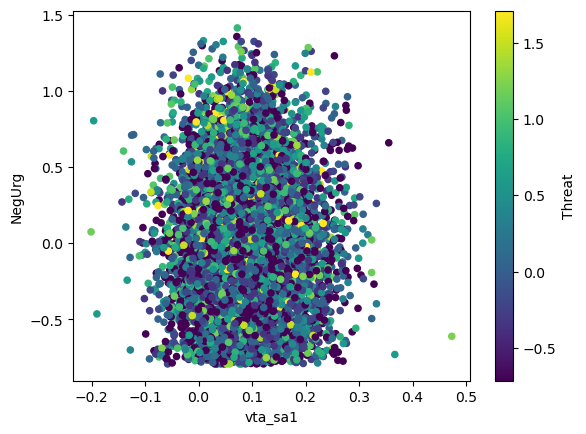

In [27]:
lf.plot.scatter(x='vta_sa1', y='NegUrg', c='Threat')

<Axes: xlabel='vta_sa1', ylabel='Aware'>

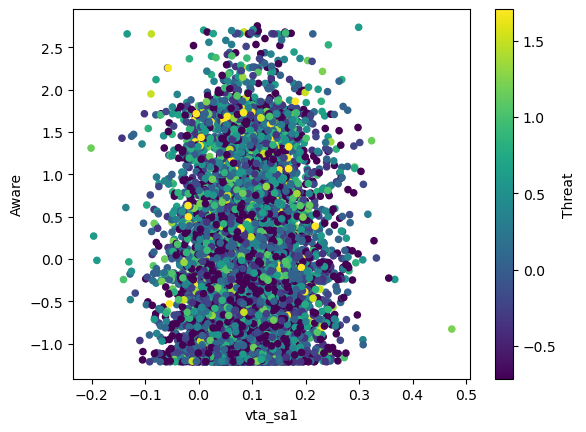

In [21]:
lf.plot.scatter(x='vta_sa1', y='Aware', c='Threat')

<Axes: xlabel='vta_sa1', ylabel='Aware'>

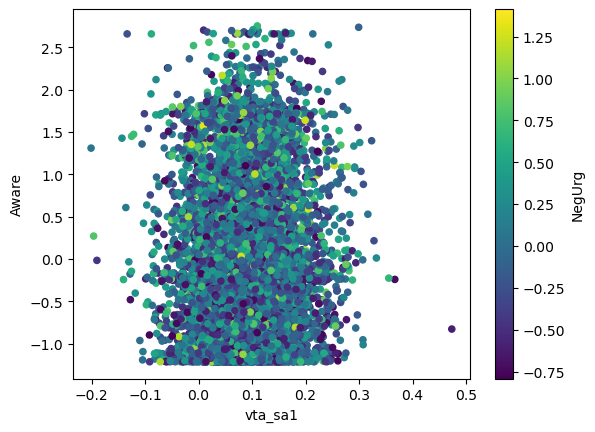

In [23]:
lf.plot.scatter(x='vta_sa1', y='Aware', c='NegUrg')

In [22]:
[c for c in lf if 'fam' in c]

['famID1', 'famID5', 'famID9']

In [23]:
lf['famID1'].value_counts()

famID1
3737.0     4
4446.0     3
2814.0     3
11776.0    3
11731.0    3
          ..
1236.0     1
6304.0     1
2737.0     1
11574.0    1
4563.0     1
Name: count, Length: 8449, dtype: int64

In [24]:
lf['famID1'].min()

0.0

In [24]:
[c for c in rser.columns if '_score' in c]

['Sders_aware_clar_score_7',
 'Sders_aware_clar_score_9',
 'Sders_awareness_score_3_7',
 'Sders_awareness_score_4_9',
 'Sders_goals_score_3_7',
 'Sders_goals_score_4_9',
 'Sders_impulse_score_3_7',
 'Sders_impulse_score_4_9',
 'Sders_nonaccept_score_3_7',
 'Sders_nonaccept_score_4_9',
 'Sders_total_score_3_7',
 'Sders_total_score_4_9',
 'ders_aware_clar_score_7',
 'ders_aware_clar_score_9',
 'ders_awareness_score_3_7',
 'ders_awareness_score_4_9',
 'ders_goals_score_3_7',
 'ders_goals_score_4_9',
 'ders_impulse_score_3_7',
 'ders_impulse_score_4_9',
 'ders_nonaccept_score_3_7',
 'ders_nonaccept_score_4_9',
 'ders_total_score_3_7',
 'ders_total_score_4_9']

In [27]:
[c for c in rser.columns if 'site' in c]

[]